# Реализация метода обратного распространения ошибки для двухслойной полностью связанной нейронной сети

<u>Цель:</u>  изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полностью связанной сети (один скрытый слой).

Выполнение практической работы предполагает решение следующих задач:
1. Изучение общей схемы метода обратного распространения ошибки.
2. Вывод математических формул для вычисления градиентов функции ошибки по параметрам нейронной сети и формул коррекции весов.
3. Проектирование и разработка программной реализации.
4. Тестирование разработанной программной реализации.
5. Подготовка отчета, содержащего минимальный объем информации по каждому этапу выполнения работы.


In [48]:
# загрузим необходимые библиотеки
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import matplotlib.pyplot as plt
import numpy as np

import cv2
import os
import random
import matplotlib.image as mpimg
import pickle
from tensorflow.keras.datasets import mnist
from PIL import Image

from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Input
from keras.models import load_model

import gradio as gr

Побочные функции. Основные фунеции расположены по тексту проекта.

In [5]:
def draw_formula_from_text(description):
    """
    Принимает текстовое описание формулы и рисует её.
    """
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.text(0.5, 0.5, description, fontsize=20, ha='center', va='center', usetex=True)
    ax.axis('off')
    plt.show()

In [2]:
def draw_neural_network(input_size, hidden_size, output_size, input_names, weight_names, activation_names):
    """
    Рисует нейронную сеть по входным данным
    """
    plt.figure(figsize=(12, 8))
    input_layer_x = np.zeros(input_size)
    input_layer_y = np.linspace(1, 0, input_size)
    hidden_layer_x = np.ones(hidden_size)
    hidden_layer_y = np.linspace(1, 0, hidden_size)
    output_layer_x = 2 * np.ones(output_size)
    output_layer_y = np.linspace(1, 0, output_size)

    for i, (x, y) in enumerate(zip(input_layer_x, input_layer_y)):
        plt.scatter(x, y, s=500, color='lightblue', edgecolor='black', linewidth=2)
        plt.text(x, y + 0.1, input_names[i], fontsize=12, ha='center', va='center')  

    for j, (x, y) in enumerate(zip(hidden_layer_x, hidden_layer_y)):
        plt.scatter(x, y, s=500, color='lightgreen', edgecolor='black', linewidth=2)
        plt.text(x, y + 0.1, activation_names[j], fontsize=12, ha='center', va='center')  

    for k, (x, y) in enumerate(zip(output_layer_x, output_layer_y)):
        plt.scatter(x, y, s=500, color='salmon', edgecolor='black', linewidth=2)
        plt.text(x, y + 0.1, f'Y{k+1}', fontsize=12, ha='center', va='center')  

    for i in range(input_size):
        for j in range(hidden_size):
            plt.plot([input_layer_x[i], hidden_layer_x[j]], [input_layer_y[i], hidden_layer_y[j]], 'k-')
            plt.text((input_layer_x[i] + hidden_layer_x[j]) / 2, (input_layer_y[i] + hidden_layer_y[j]) / 2, weight_names[i][j], fontsize=10, ha='center', va='center')

    for j in range(hidden_size):
        for k in range(output_size):
            plt.plot([hidden_layer_x[j], output_layer_x[k]], [hidden_layer_y[j], output_layer_y[k]], 'k--')  # Используем пунктирную линию для выходных данных
            plt.text((hidden_layer_x[j] + output_layer_x[k]) / 2, (hidden_layer_y[j] + output_layer_y[k]) / 2, f'w{j+1}{k+1}', fontsize=10, ha='center', va='center')

    plt.annotate('Input Layer (X)', xy=(-0.5, 0.5), fontsize=14, ha='center')
    plt.annotate('Hidden Layer (H)', xy=(0.5, 0.5), fontsize=14, ha='center')
    plt.annotate('Output Layer (Y)', xy=(2.5, 0.5), fontsize=14, ha='center')

    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 1.5)
    plt.axis('off')
    plt.title('Образец простой полносвязной сети', fontsize=16)
    plt.show()

## Часть 1. Вывод математических формул

В данной части будут выведены и описаны формулы для вычисления градиентов функции ошибки по параметрам нейронной сети и формулы коррекции весов.

Для начала рассмотрим простую полносвязную нейронную сеть.

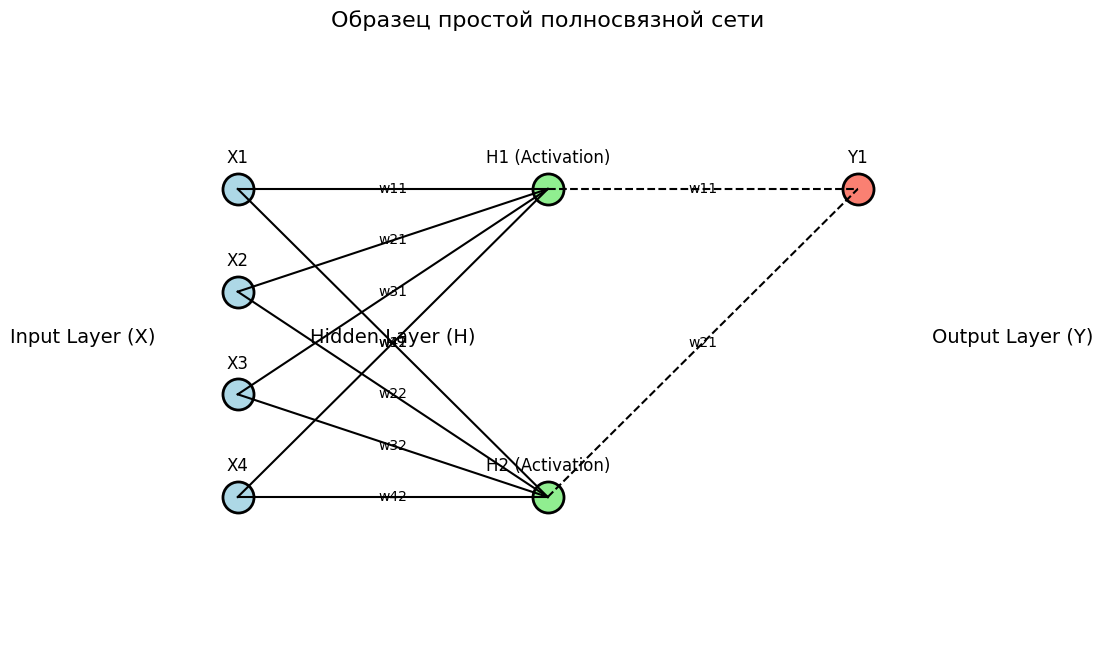

In [52]:
input_names = ['X1', 'X2', 'X3','X4']
weight_names = [
    ['w11', 'w12'],
    ['w21', 'w22'],
    ['w31', 'w32'],
    ['w41', 'w42']
]
activation_names = ['H1 (Activation)', 'H2 (Activation)']
draw_neural_network(input_size=4, hidden_size=2, output_size=1,
                    input_names=input_names,
                    weight_names= weight_names,
                    activation_names=activation_names)

Для начала обозначим все формулы, по которым построена нейронная сеть.

### Общие формулы

Выход на каждом слое l вычисляется по общей формуле:


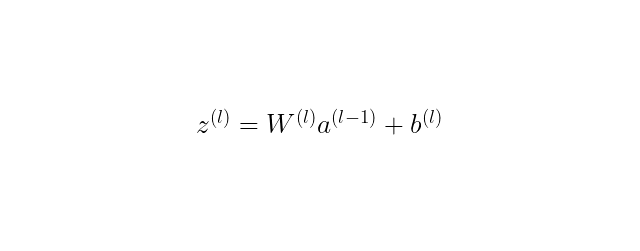

Где: 
 z - входные данные слоя 
 W - веса слоя 
 a - выходные данные предыдущего слоя 
 b - смещение слоя


In [53]:
print('Выход на каждом слое l вычисляется по общей формуле:')
latex = r"$z^{(l)} = W^{(l)} a^{(l-1)} + b^{(l)}$"
draw_formula_from_text(latex)
print('Где: \n z - входные данные слоя \n W - веса слоя \n a - выходные данные предыдущего слоя \n b - смещение слоя')

Для единственного скрытого слоя выходные данные слоя равны входным данным сети, и формула превращается:


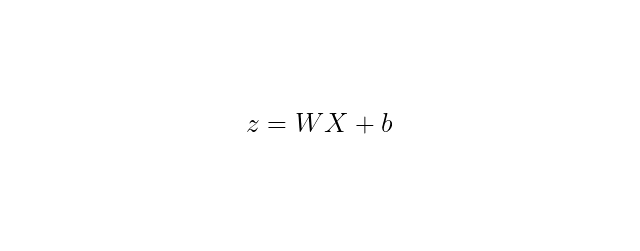

Для итогового слоя z=y_pred, то есть выходные значения это и есть предсказанные значения


In [54]:
print('Для единственного скрытого слоя выходные данные слоя равны входным данным сети, и формула превращается:')
latex = r"$z = W X + b$"
draw_formula_from_text(latex)
print('Для итогового слоя z=y_pred, то есть выходные значения это и есть предсказанные значения')

Входные и выходные данные в слое связаны через функцию активации:


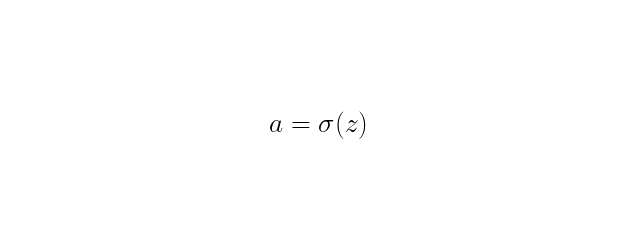

In [55]:
print('Входные и выходные данные в слое связаны через функцию активации:')
latex = r"$a = \sigma(z)$"
draw_formula_from_text(latex)

Для выходного слоя в задаче классификации приминяется softmax


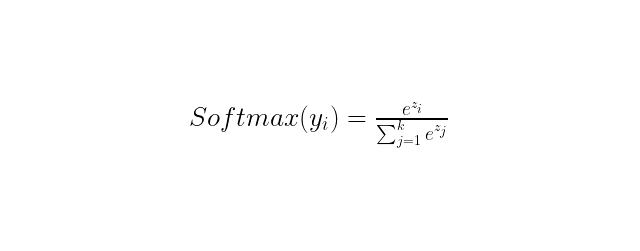

Где: 
 k - количества классов, в нашем случае 10


In [56]:
print('Для выходного слоя в задаче классификации приминяется softmax')
latex = r"$Softmax(y_i) = \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$"
draw_formula_from_text(latex)
print('Где: \n k - количества классов, в нашем случае 10')

- вычисляется для каждого класса. В нашем случае это 10 классов цифр.
- заключается в прообразовании вектора значений в вероятностное распределение, которое суммируется до 1.

Функцией ошибки может быть используемая для задач классификации - кросс-энтропия. 
 Эта функция известна как отрицательная логирифмическая вероятность.


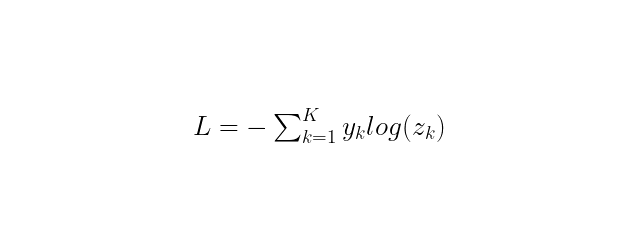

In [57]:
print('Функцией ошибки может быть используемая для задач классификации - кросс-энтропия. \n Эта функция известна как отрицательная логирифмическая вероятность.')
latex = r"$L = {-\sum_{k=1}^K y_k log(z_k)}$"
draw_formula_from_text(latex)

Фактически это отрицательная сумма произведения вероятности истинного класса и логарифма вероятности предсказанного класса.
- Если сеть хорошо предсказывает правильный класс, то z_k для этого класса будет близко к 1, и ошибка будет маленькой.
- Если сеть плохо предсказывает, то z_k будет маленьким, и ошибка будет большой.

### Расчет ошибки на выходном слое


Производная функции ошибки L слоя l по выходным данным z рассчитывается:


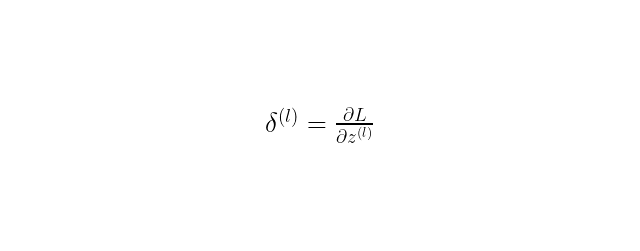

In [58]:
print('Производная функции ошибки L слоя l по выходным данным z рассчитывается:')
latex = r"$\delta^{(l)} = \frac{\partial L}{\partial z^{(l)}}$"
draw_formula_from_text(latex)

Найдем производную softmax:
Производная внутри одной и той же компоненты


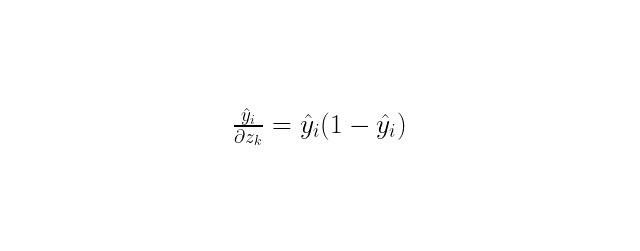

Производная между разными компонентами


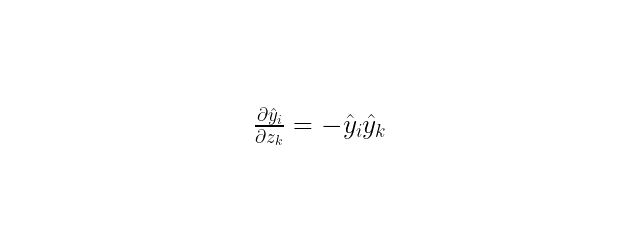

In [59]:
print('Найдем производную softmax:')
print('Производная внутри одной и той же компоненты')
latex = r"$\frac{\hat{y}_i}{\partial z_k} = \hat{y}_i (1 - \hat{y}_i)$"
draw_formula_from_text(latex)
print('Производная между разными компонентами')
latex = r"$\frac{\partial \hat{y}_i}{\partial z_k} = -\hat{y}_i \hat{y}_k$"
draw_formula_from_text(latex)

Найдем производную кросс-энтропии:
Формула ошибки кросс-энтропии:


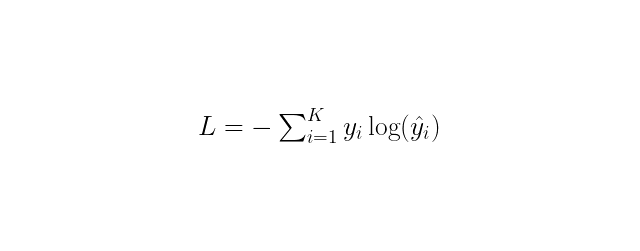

Возьмем производную ошибки до выходу до применения softmax:


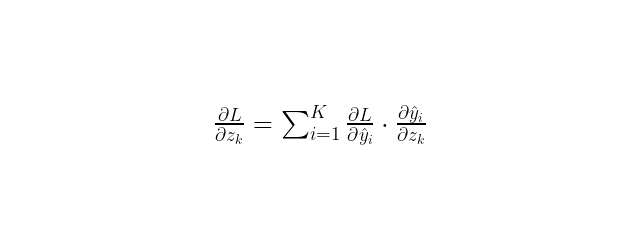

Найдем частную производную функции ошибки по предсказанным вероятностям


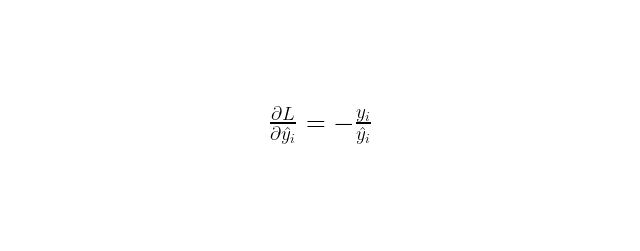

Подставим в формулу


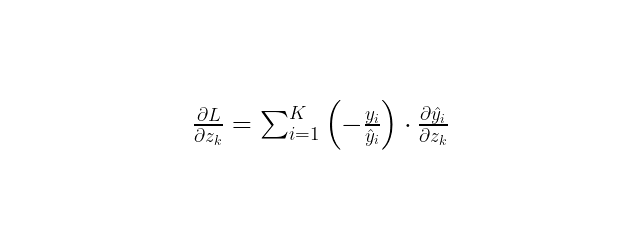

In [60]:
print('Найдем производную кросс-энтропии:')
print('Формула ошибки кросс-энтропии:')
latex = r"$L = -\sum_{i=1}^K y_i \log(\hat{y}_i)$"
draw_formula_from_text(latex)
print('Возьмем производную ошибки до выходу до применения softmax:')
latex = r"$\frac{\partial L}{\partial z_k} = \sum_{i=1}^K \frac{\partial L}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial z_k}$"
draw_formula_from_text(latex)
print('Найдем частную производную функции ошибки по предсказанным вероятностям')
latex = r"$\frac{\partial L}{\partial \hat{y}_i} = -\frac{y_i}{\hat{y}_i}$"
draw_formula_from_text(latex)
print('Подставим в формулу')
latex = r"$\frac{\partial L}{\partial z_k} = \sum_{i=1}^K \left( -\frac{y_i}{\hat{y}_i} \right) \cdot \frac{\partial \hat{y}_i}{\partial z_k}$"
draw_formula_from_text(latex)


Подставим в эту формулу для производной softmax
Для разных компонент


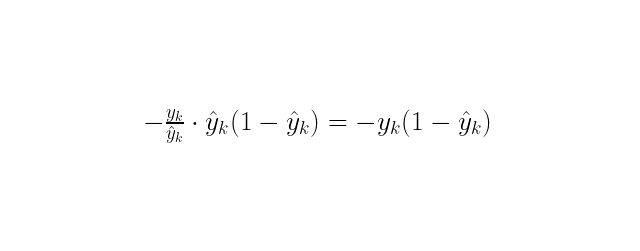

Для одинаковых компонент


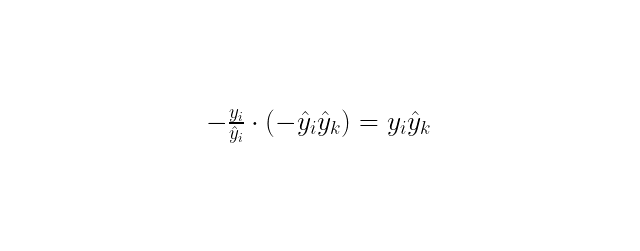

In [61]:
print('Подставим в эту формулу для производной softmax')
print('Для разных компонент')
latex = r"$-\frac{y_k}{\hat{y}_k} \cdot \hat{y}_k (1 - \hat{y}_k) = -y_k (1 - \hat{y}_k)$"
draw_formula_from_text(latex)
print('Для одинаковых компонент')
latex = r"$-\frac{y_i}{\hat{y}_i} \cdot (-\hat{y}_i \hat{y}_k) = y_i \hat{y}_k$"
draw_formula_from_text(latex)

Объединим оба случая:


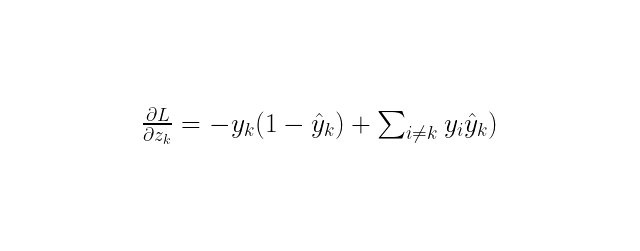

Так как мы использует OneHotEncoder,  и y=0, для всех случаев разных компонент, то остается:


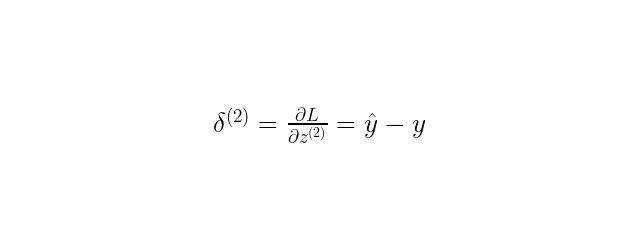

In [62]:
print('Объединим оба случая:')
latex = r"$\frac{\partial L}{\partial z_k} = -y_k (1 - \hat{y}_k) + \sum_{i \neq k} y_i \hat{y}_k)$"
draw_formula_from_text(latex)
print('Так как мы использует OneHotEncoder,  и y=0, для всех случаев разных компонент, то остается:')
latex = r"$\delta^{(2)} = \frac{\partial L}{\partial z^{(2)}} = \hat{y} - y$"
draw_formula_from_text(latex)

### Расчет градиентов функции ошибки по параметрам выходного слоя

Линейная комбинация выходного слоя


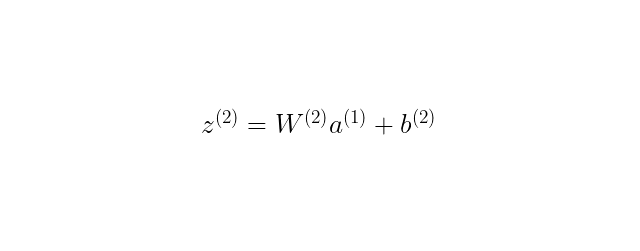

Так как выход z зависит от весомв W, то используя цепное правило диффференцирования:


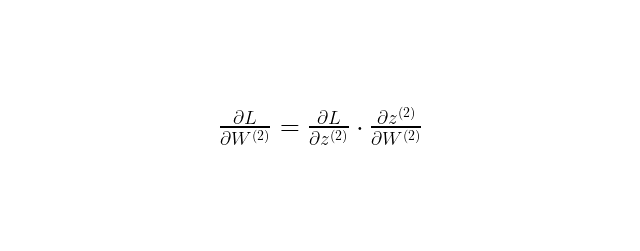

In [63]:
print('Линейная комбинация выходного слоя')
latex = r"$z^{(2)} = W^{(2)} a^{(1)} + b^{(2)}$"
draw_formula_from_text(latex)
print('Так как выход z зависит от весомв W, то используя цепное правило диффференцирования:')
latex = r"$\frac{\partial L}{\partial W^{(2)}} = \frac{\partial L}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial W^{(2)}}$"
draw_formula_from_text(latex)

Производная для каждого выхода нейрона на выходном слое по весу равна


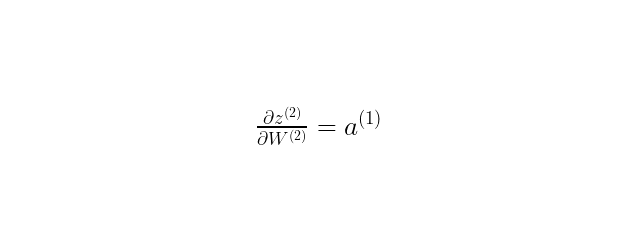

Подставляем уже известные Функции:


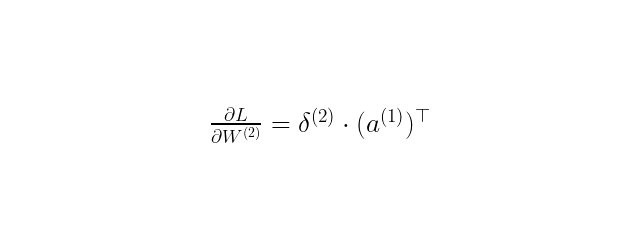

где 
 первый множитель - вектор ошибки на выходном слое, а второй вектор выходов скрытого слоя. 
 результирующая матрица имеет такой же размер как матрица весов


In [64]:
print('Производная для каждого выхода нейрона на выходном слое по весу равна')
latex = r"$  \frac{\partial z^{(2)}}{\partial W^{(2)}} = a^{(1)}$"
draw_formula_from_text(latex)
print('Подставляем уже известные Функции:')
latex = r"$\frac{\partial L}{\partial W^{(2)}} = \delta^{(2)} \cdot (a^{(1)})^\top$"
draw_formula_from_text(latex)
print('где \n первый множитель - вектор ошибки на выходном слое, а второй вектор выходов скрытого слоя. \n результирующая матрица имеет такой же размер как матрица весов')

С учетом того, что смещение добавляется одинаково ко всем выходам,
 производная выхода по смещению будет равно 1,то формула для смещения:


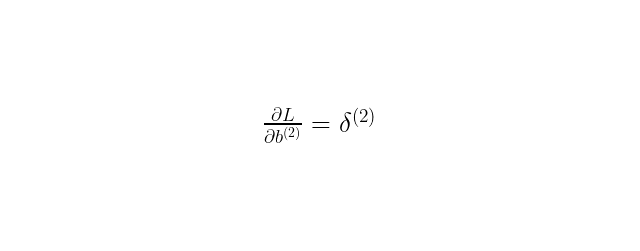

In [65]:
print('С учетом того, что смещение добавляется одинаково ко всем выходам,\n производная выхода по смещению будет равно 1,то формула для смещения:')
latex = r"$ \frac{\partial L}{\partial b^{(2)}} = \delta^{(2)}$"
draw_formula_from_text(latex)

### Расчет ошибки скрытого слоя

Нпйдем производную ошибки по входу скрытого слоя


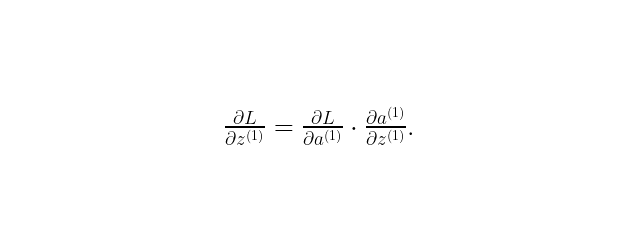

In [66]:
print('Нпйдем производную ошибки по входу скрытого слоя')
latex = r"$\frac{\partial L}{\partial z^{(1)}} = \frac{\partial L}{\partial a^{(1)}} \cdot \frac{\partial a^{(1)}}{\partial z^{(1)}}.$"
draw_formula_from_text(latex)

Найдем 1 множитель
Функция ошибки L зависит от выхода слоя через веса и входные данные


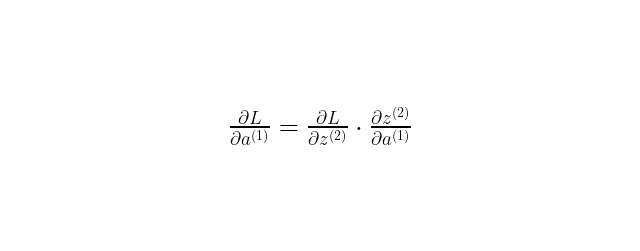

Производная входа в скрытый слок от выхода 1 слоя


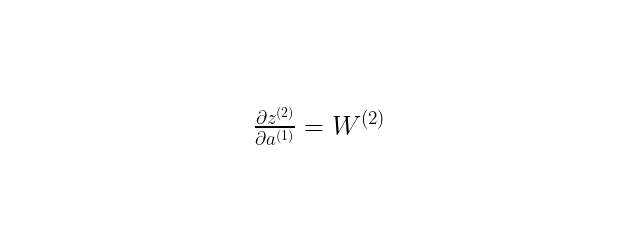

Подставляем


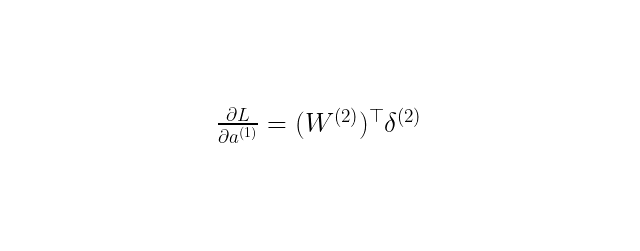

In [67]:
print('Найдем 1 множитель')
print('Функция ошибки L зависит от выхода слоя через веса и входные данные')
latex = r"$\frac{\partial L}{\partial a^{(1)}} = \frac{\partial L}{\partial z^{(2)}} \cdot \frac{\partial z^{(2)}}{\partial a^{(1)}}$"
draw_formula_from_text(latex)
print('Производная входа в скрытый слок от выхода 1 слоя')
latex = r"$\frac{\partial z^{(2)}}{\partial a^{(1)}} = W^{(2)}$"
draw_formula_from_text(latex)
print('Подставляем')
latex = r"$\frac{\partial L}{\partial a^{(1)}} = (W^{(2)})^\top \delta^{(2)}$"
draw_formula_from_text(latex)

Найдем 2 множитель
переход от входных данных к выходным осуществляется через функцию активации


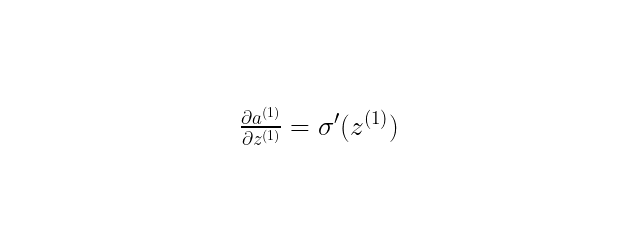

Подставляем


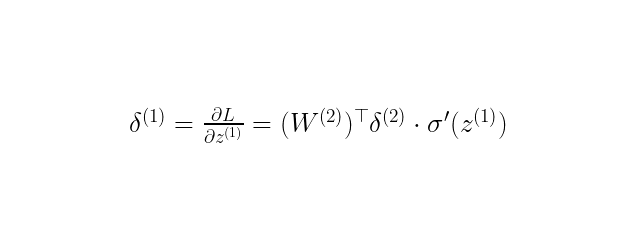

In [68]:
print('Найдем 2 множитель')
print('переход от входных данных к выходным осуществляется через функцию активации')
latex = r"$\frac{\partial a^{(1)}}{\partial z^{(1)}} = \sigma'(z^{(1)})$"
draw_formula_from_text(latex)
print('Подставляем')
latex = r"$\delta^{(1)} = \frac{\partial L}{\partial z^{(1)}} = (W^{(2)})^\top \delta^{(2)} \cdot \sigma'(z^{(1)})$"
draw_formula_from_text(latex)

### Расчет градиентов функции по параментам скрытго слоя.

Используем вывод, указынный для выходного слоя

Для весов:


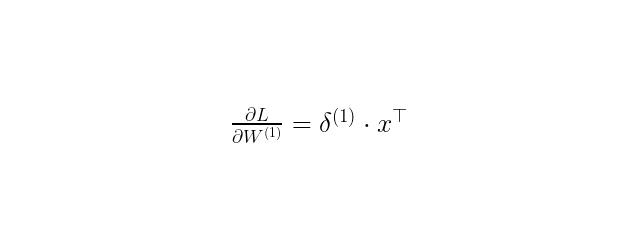

Для смещения:


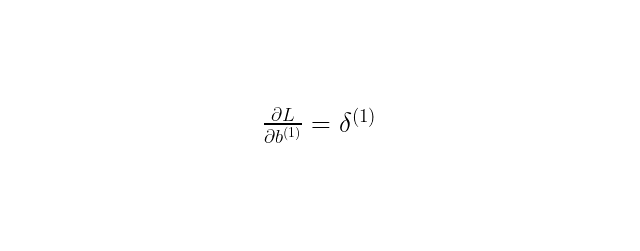

In [69]:
print('Для весов:')
latex = r"$\frac{\partial L}{\partial W^{(1)}} = \delta^{(1)} \cdot x^\top$"
draw_formula_from_text(latex)
print('Для смещения:')
latex = r"$\frac{\partial L}{\partial b^{(1)}} = \delta^{(1)}$"
draw_formula_from_text(latex)

###  обновление параметров

После вычисления градиентов параметры обновляются с использованием градиентного спуска. Шаг градиентного спуска задается исследователем.

Для весов скрытого слоя:


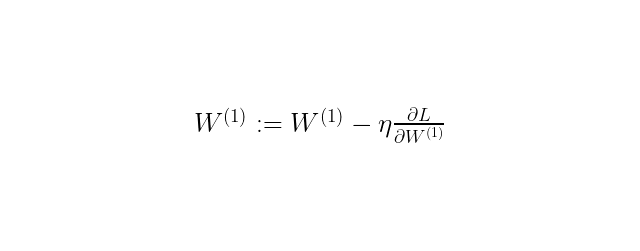

Для смещения скрытого слоя:


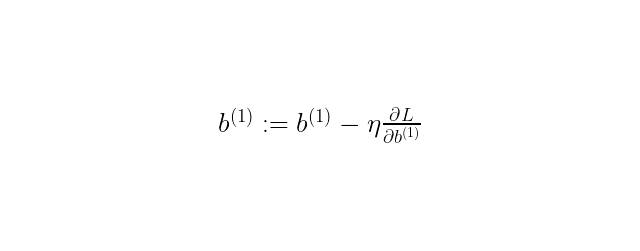

Для весов выходного слоя:


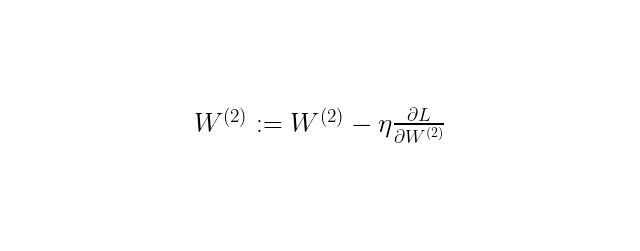

Для смещения выходного слоя:


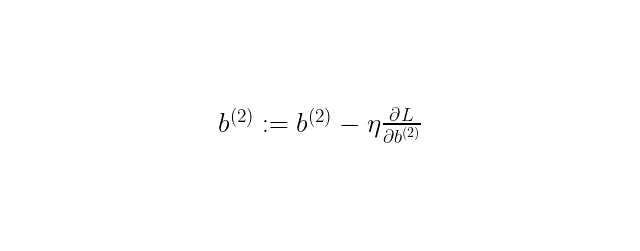

In [70]:
print('Для весов скрытого слоя:')
latex = r"$W^{(1)} := W^{(1)} - \eta \frac{\partial L}{\partial W^{(1)}}$"
draw_formula_from_text(latex)
print('Для смещения скрытого слоя:')
latex = r"$b^{(1)} := b^{(1)} - \eta \frac{\partial L}{\partial b^{(1)}}$"
draw_formula_from_text(latex)
print('Для весов выходного слоя:')
latex = r"$W^{(2)} := W^{(2)} - \eta \frac{\partial L}{\partial W^{(2)}}$"
draw_formula_from_text(latex)
print('Для смещения выходного слоя:')
latex = r"$b^{(2)} := b^{(2)} - \eta \frac{\partial L}{\partial b^{(2)}}$"
draw_formula_from_text(latex)

## Часть 2. Метод обратного распространения ошибки


В данной часть будет описан алгоитм метода обратного распроистранения ошибки

<u>Шаг 1</u> Инициализация параментов.

Задаются случайные начальные параментры для весов и смещения скрытого и выходного слоя

<u>Шаг 2</u> Прямое распространение.


Вычисляется вход скрытого слоя:


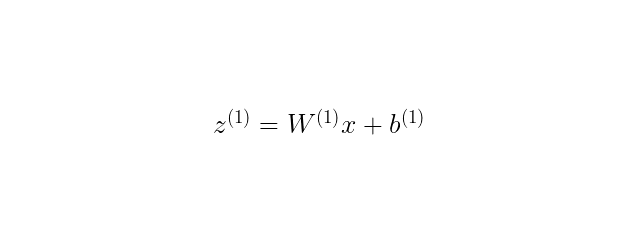

Применяется функция активации:


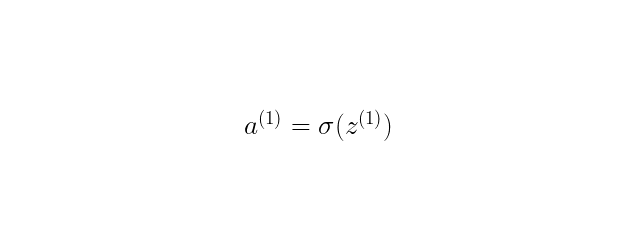

Вычисляеся входные даные итогового слоя :


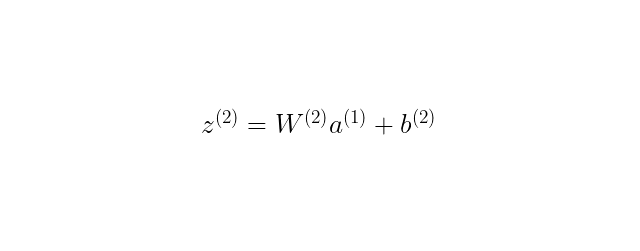

Применяется softmax:


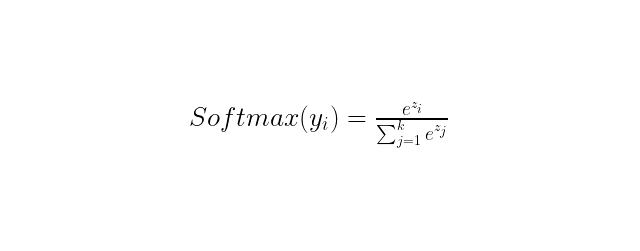

In [71]:
print('Вычисляется вход скрытого слоя:')
latex = r"$z^{(1)} = W^{(1)} x + b^{(1)}$"
draw_formula_from_text(latex)
print('Применяется функция активации:')
latex = r"$a^{(1)} = \sigma(z^{(1)})$"
draw_formula_from_text(latex)
print('Вычисляеся входные даные итогового слоя :')
latex = r"$z^{(2)} = W^{(2)}a^{(1)} + b^{(2)}$"
draw_formula_from_text(latex)
print('Применяется softmax:')
latex = r"$Softmax(y_i) = \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}$"
draw_formula_from_text(latex)

<u>Шаг 3</u> Вычисление функции ошибки

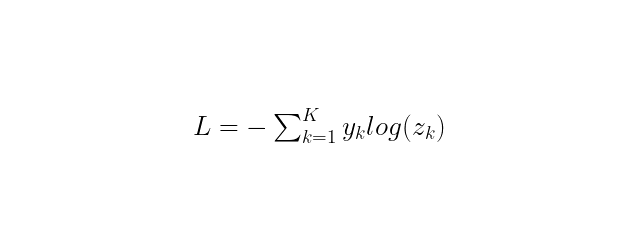

In [72]:
latex = r"$L = {-\sum_{k=1}^K y_k log(z_k)}$"
draw_formula_from_text(latex)

<u>Шаг 4</u> Обратное распространение ошибки

Вычисляем ошибку выходного слоя:


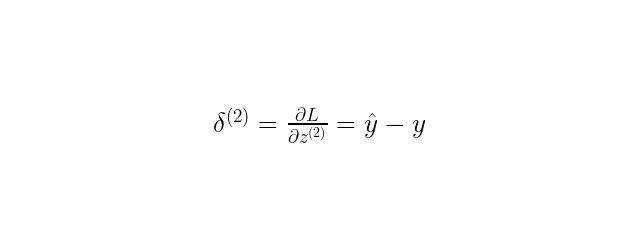

Применяется ошибку скрытого слоя:


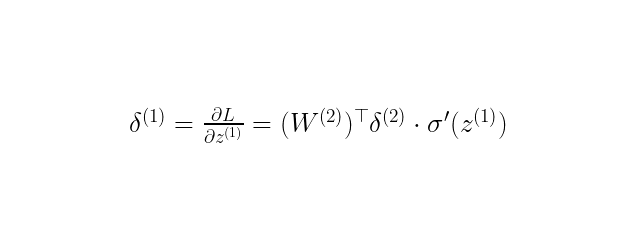

In [73]:
print('Вычисляем ошибку выходного слоя:')
latex = r"$\delta^{(2)} = \frac{\partial L}{\partial z^{(2)}} = \hat{y} - y$"
draw_formula_from_text(latex)
print('Применяется ошибку скрытого слоя:')
latex = r"$\delta^{(1)} = \frac{\partial L}{\partial z^{(1)}} = (W^{(2)})^\top \delta^{(2)} \cdot \sigma'(z^{(1)})$"
draw_formula_from_text(latex)

Вычисляем градиенты:

Для весов скрытого слоя:


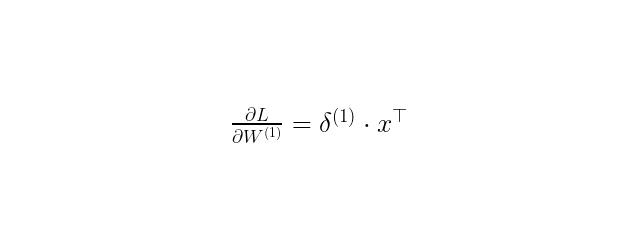

Для смещения скрытого слоя:


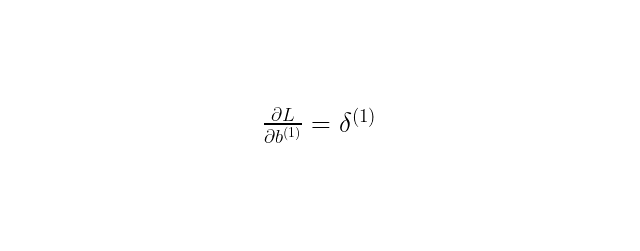

Для весов выходного слоя :


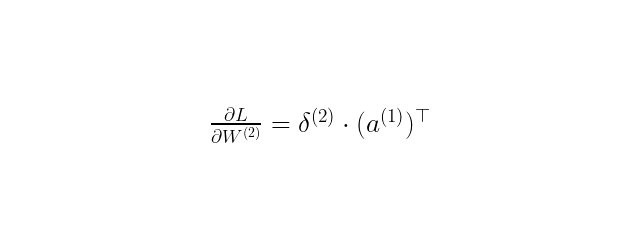

Для смещения выходного слоя:


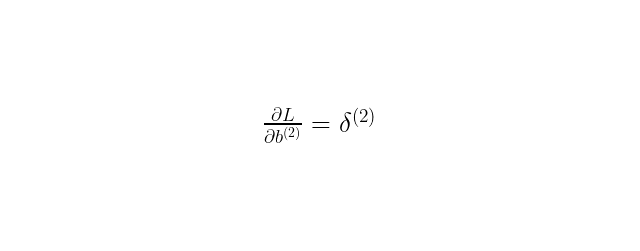

In [74]:
print('Для весов скрытого слоя:')
latex = r"$\frac{\partial L}{\partial W^{(1)}} = \delta^{(1)} \cdot x^\top$"
draw_formula_from_text(latex)
print('Для смещения скрытого слоя:')
latex = r"$\frac{\partial L}{\partial b^{(1)}} = \delta^{(1)}$"
draw_formula_from_text(latex)
print('Для весов выходного слоя :')
latex = r"$\frac{\partial L}{\partial W^{(2)}} = \delta^{(2)} \cdot (a^{(1)})^\top$"
draw_formula_from_text(latex)
print('Для смещения выходного слоя:')
latex = r"$\frac{\partial L}{\partial b^{(2)}} = \delta^{(2)}$"
draw_formula_from_text(latex)

<u>Шаг 5</u> Обновление параметров

Для весов скрытого слоя:


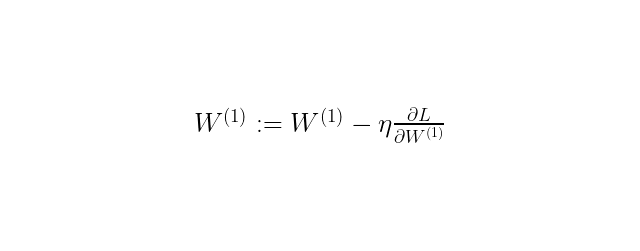

Для смещения скрытого слоя:


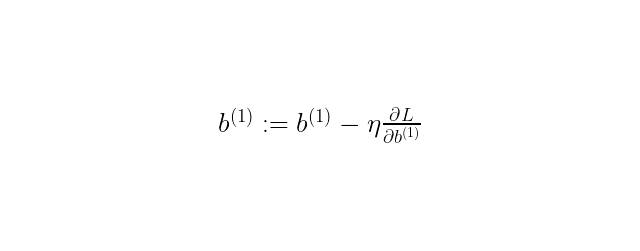

Для весов выходного слоя:


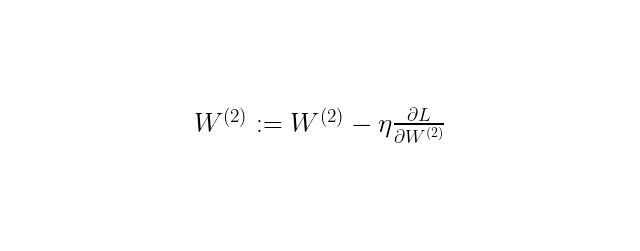

Для смещения выходного слоя:


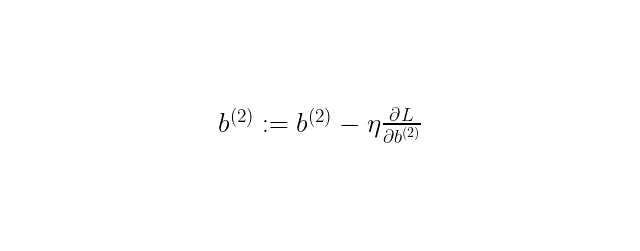

In [75]:
print('Для весов скрытого слоя:')
latex = r"$W^{(1)} := W^{(1)} - \eta \frac{\partial L}{\partial W^{(1)}}$"
draw_formula_from_text(latex)
print('Для смещения скрытого слоя:')
latex = r"$b^{(1)} := b^{(1)} - \eta \frac{\partial L}{\partial b^{(1)}}$"
draw_formula_from_text(latex)
print('Для весов выходного слоя:')
latex = r"$W^{(2)} := W^{(2)} - \eta \frac{\partial L}{\partial W^{(2)}}$"
draw_formula_from_text(latex)
print('Для смещения выходного слоя:')
latex = r"$b^{(2)} := b^{(2)} - \eta \frac{\partial L}{\partial b^{(2)}}$"
draw_formula_from_text(latex)

<u>Шаг 6 </u>Повторять шаги 2–5 для каждого примера из обучающей выборки , пока сеть не обучится.

## Часть 3. Программная реализация кода

В данной части будут программно реализованы формулы, описанные выше.

<u>Шаг 1</u> Инициализация параметров

In [15]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Инициализация весов и смещений.
    """
    np.random.seed(42)
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return W1, b1, W2, b2

<u>Шаг 2</u> Прямое распространение

Функцией активации скрытого слоя используем функцию активациии relu

In [16]:
def relu(z):
    return np.maximum(0, z)

In [17]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [18]:
def forward_propagation(X, W1, b1, W2, b2):
    """
    Прямое распространение.
    """
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2

<u>Шаг 3</u> Обратное распространение ошибки

Вычисляем производную функции активации. Эта операция позволяет корректно учитывать влияние функции активации ReLU на градиенты.

In [19]:
def relu_derivative(z):
    return (z > 0).astype(float)

In [20]:
def backward_propagation(X, Y, Z1, A1, A2, W2):
    """
    Обратное распространение.
    """
    m = X.shape[1]
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    return dW1, db1, dW2, db2

<u>Шаг 4</u> Обновление параметров

In [21]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """
    Обновление параметров нейронной сети.
    """
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    return W1, b1, W2, b2

## Часть 4. Разработка приложения классификации рукописных чисел.

### Загрузка данных

Так как данные есть в открытом доступе, можно загрузить их и сохранить в собственной директории. Данные сразу делятся на тестовую и тренировочную выборку.

In [24]:
def save_mnist_images(output_dir):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    train_dir = os.path.join(output_dir, 'train')
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)

    for i in range(10):
        digit_dir = os.path.join(train_dir, str(i))
        if not os.path.exists(digit_dir):
            os.makedirs(digit_dir)

        indices = np.where(y_train == i)[0]

        for j, index in enumerate(indices):
            image = x_train[index]
            img = Image.fromarray(image)
            img.save(os.path.join(digit_dir, f"{j}.png"))


    test_dir = os.path.join(output_dir, 'test')
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    for i in range(10):
        digit_dir = os.path.join(test_dir, str(i))
        if not os.path.exists(digit_dir):
            os.makedirs(digit_dir)

        indices = np.where(y_test == i)[0]

        for j, index in enumerate(indices):
            image = x_test[index]
            img = Image.fromarray(image)
            img.save(os.path.join(digit_dir, f"{j}.png"))


output_directory = "mnist_images"
save_mnist_images(output_directory)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### разработка модели

Запишем недостающие функции, включающие в себя этап предобработки данных, объединения и реализации функций и этап тестирования приложения.

####<u>Предобработка данных</u>

In [25]:
def one_hot_encode(labels, num_classes):
    """
    Приминение OneHotEncoding к target
    """
    one_hot = np.zeros((num_classes, labels.shape[0]))
    one_hot[labels, np.arange(labels.shape[0])] = 1
    return one_hot

In [26]:
def load_mnist_from_directory(directory):
    """
    Загружает данные из указанных директорий
    """
    images = []
    labels = []
    for label in range(10):
        label_dir = os.path.join(directory, str(label))
        for file_name in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file_name)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            images.append(img.flatten() / 255.0)
            labels.append(label)
    return np.array(images), np.array(labels)

In [27]:
# Загрузка данных
x_train, y_train = load_mnist_from_directory("/content/mnist_images/train")
x_test, y_test = load_mnist_from_directory("/content/mnist_images/test")

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")

x_train: (60000, 784), y_train: (60000,)


Посмотрим на имеющиеся изображения

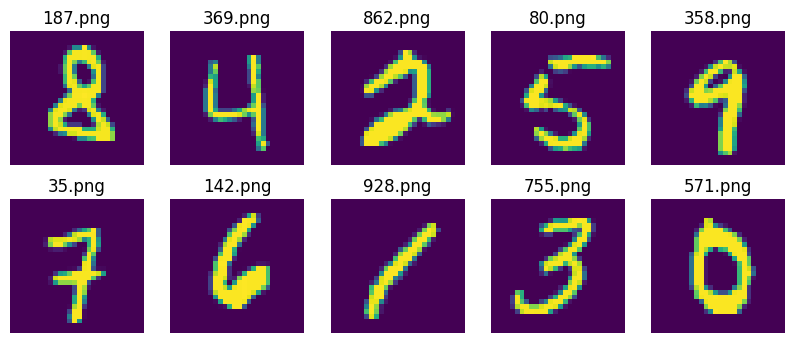

In [28]:
subfolders = [f.path for f in os.scandir('/content/mnist_images/test') if f.is_dir()]
selected_images = []

for folder in subfolders:
    images = [f for f in os.listdir(folder) if f.endswith(('jpg', 'jpeg', 'png', 'gif'))]
    if images:  # Если в папке есть изображения
        selected_image = random.choice(images)
        selected_images.append(os.path.join(folder, selected_image))

plt.figure(figsize=(10, 4))
for i, image_path in enumerate(selected_images[:10]):
    img = mpimg.imread(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
plt.show()

In [29]:
# Гиперпараметры
input_size = 784
hidden_size = 128
output_size = 10

# предобработка
x_train = x_train.T
x_test = x_test.T

y_train_one_hot = one_hot_encode(y_train, output_size)
y_test_one_hot = one_hot_encode(y_test, output_size)

####<u>Обучение модели</u>

In [30]:
def train(X, Y, input_size, hidden_size, output_size, learning_rate, num_iterations):
    """
    Обучение модели. Соединение всех функций в один процесс
    """
    list_loss = []
    W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)
    for i in range(num_iterations):
        Z1, A1, Z2, A2 = forward_propagation(X, W1, b1, W2, b2)
        loss = -np.mean(np.sum(Y * np.log(A2 + 1e-8), axis=0))
        list_loss.append(loss)
        dW1, db1, dW2, db2 = backward_propagation(X, Y, Z1, A1, A2, W2)
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        if i % 100 == 0:
            print(f"Итерация {i}: ошибка = {loss}")
    return W1, b1, W2, b2, list_loss

In [31]:
iterations = 1000
learning_rate = 0.01

# Обучение модели
W1, b1, W2, b2,list_a  = train(x_train, y_train_one_hot, input_size, hidden_size, output_size, learning_rate, iterations)


Итерация 0: ошибка = 2.3028354479841875
Итерация 100: ошибка = 2.2904548476417683
Итерация 200: ошибка = 2.268236738941945
Итерация 300: ошибка = 2.221310406457631
Итерация 400: ошибка = 2.1265796803807855
Итерация 500: ошибка = 1.959677600798759
Итерация 600: ошибка = 1.719154886242521
Итерация 700: ошибка = 1.4532419710543218
Итерация 800: ошибка = 1.2257548108086218
Итерация 900: ошибка = 1.0547211119947926


####<u>Тестирование модели</u>

In [32]:
def predict(X, W1, b1, W2, b2):
    """
    Предсказание
    """
    _, _, _, A2 = forward_propagation(X, W1, b1, W2, b2)
    return np.argmax(A2, axis=0)

In [33]:
# Тестирование модели
y_pred = predict(x_test, W1, b1, W2, b2)
accuracy = np.mean(y_pred == y_test)
print(f"Точность на тестовых данных: {accuracy * 100:.2f}%")

Точность на тестовых данных: 79.69%


####<u>Тестирование с иными гиперпараметрами</u>

In [34]:
iterations = 1000
learning_rate = 1.5

# Обучение модели
W1, b1, W2, b2,list_b  = train(x_train, y_train_one_hot, input_size, hidden_size, output_size, learning_rate, iterations)


Итерация 0: ошибка = 2.3028354479841875
Итерация 100: ошибка = 1.1459489427062897
Итерация 200: ошибка = 0.5668262733417595
Итерация 300: ошибка = 0.3197641898776689
Итерация 400: ошибка = 0.2568645385903507
Итерация 500: ошибка = 0.22903603270514175
Итерация 600: ошибка = 0.21015640069835775
Итерация 700: ошибка = 0.19708120549320537
Итерация 800: ошибка = 0.18706743536971607
Итерация 900: ошибка = 0.1762271912679379


In [35]:
# Тестирование модели
y_pred = predict(x_test, W1, b1, W2, b2)
accuracy = np.mean(y_pred == y_test)
print(f"Точность на тестовых данных: {accuracy * 100:.2f}%")

Точность на тестовых данных: 93.09%


In [36]:
iterations = 1000
learning_rate = 0.7

# Обучение модели
W1, b1, W2, b2,list_c  = train(x_train, y_train_one_hot, input_size, hidden_size, output_size, learning_rate, iterations)


Итерация 0: ошибка = 2.3028354479841875
Итерация 100: ошибка = 0.3005996957931573
Итерация 200: ошибка = 0.21354976798195727
Итерация 300: ошибка = 0.1729325518081808
Итерация 400: ошибка = 0.14612364922666174
Итерация 500: ошибка = 0.1264675776281579
Итерация 600: ошибка = 0.11120003652062481
Итерация 700: ошибка = 0.09895753669040393
Итерация 800: ошибка = 0.08887257456278169
Итерация 900: ошибка = 0.08046231955805226


In [37]:
# Тестирование модели
y_pred = predict(x_test, W1, b1, W2, b2)
accuracy = np.mean(y_pred == y_test)
print(f"Точность на тестовых данных: {accuracy * 100:.2f}%")

Точность на тестовых данных: 97.25%


Отобразим полученные результаты на графике

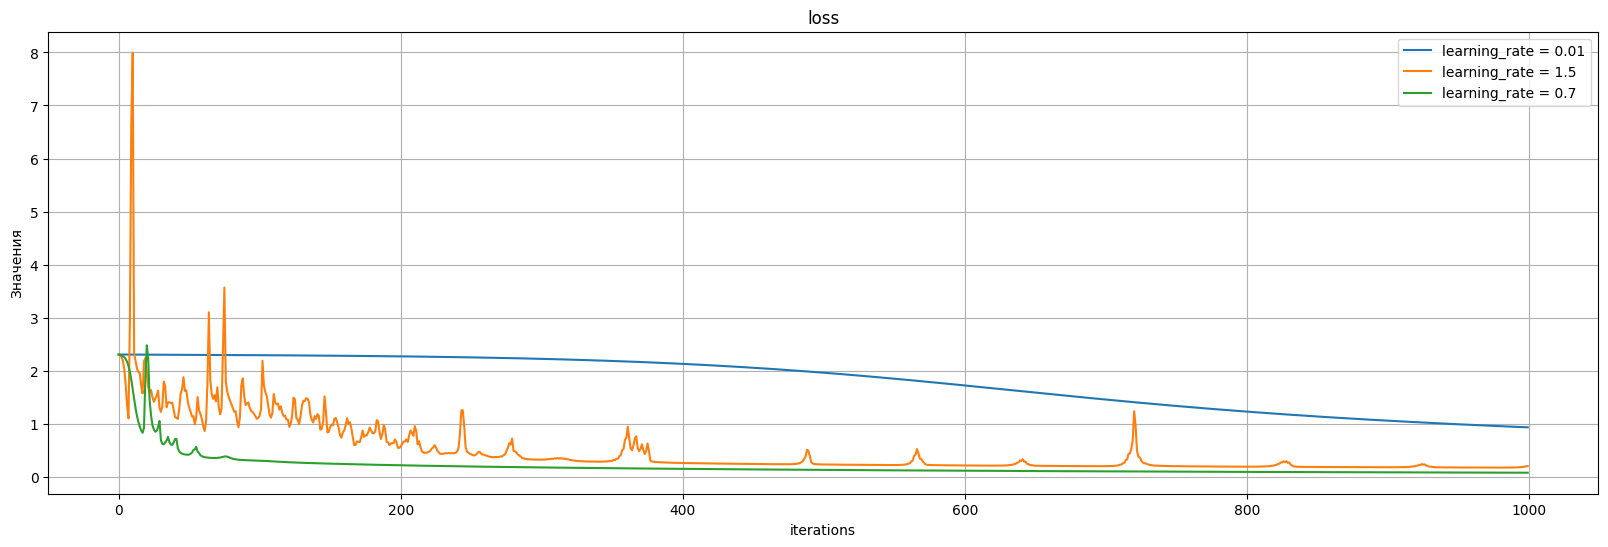

In [38]:
x_indices = list(range(len(list_a)))
plt.figure(figsize=(20, 6))
plt.plot(x_indices, list_a, label='learning_rate = 0.01')
plt.plot(x_indices, list_b, label='learning_rate = 1.5')
plt.plot(x_indices, list_c, label='learning_rate = 0.7')
plt.title('loss')
plt.xlabel('iterations')
plt.ylabel('Значения')
plt.legend()
plt.grid()
plt.show()

Модель с параментром learning_rate( скорость обучения) равном 0.01 обучается медленно, с параментром равным 1.5 переобучается. Переобучение видно по графику значения ошибки, который менее плавный, чем остальные.

Оптимально по скорости и параметрам модель с средними гиперпараметрами.

##Часть 5. Модель на Keras

In [40]:
# загрузим данные
(x_train, y_train),(x_test,y_test) = mnist.load_data()

In [41]:
# проведем предобработку
x_train = x_train/255
x_test = x_test/255

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [42]:
# Создадим модель
model = Sequential()
model.add(Input(shape=(784,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
# обучим модель
model.fit(x_train.reshape(-1,784),y_train,batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8383 - loss: 0.5928 - val_accuracy: 0.9482 - val_loss: 0.1829
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9534 - loss: 0.1625 - val_accuracy: 0.9647 - val_loss: 0.1254
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9719 - loss: 0.1010 - val_accuracy: 0.9683 - val_loss: 0.1074
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9789 - loss: 0.0752 - val_accuracy: 0.9720 - val_loss: 0.0961
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9840 - loss: 0.0554 - val_accuracy: 0.9732 - val_loss: 0.0871
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9873 - loss: 0.0456 - val_accuracy: 0.9753 - val_loss: 0.0816
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9911 - loss: 0.0334 - val_accuracy: 0.9762 - val_loss: 0.0817
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9934 - loss: 0.0280 - val_accurac

In [44]:
# протестируем модель
score = model.evaluate(x_test.reshape(-1,784), y_test, verbose=0)
print('test loss:', score[0])
print('test accuracy:', score[1])

test loss: 0.07259631156921387
test accuracy: 0.9785000085830688


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Prediction: 1


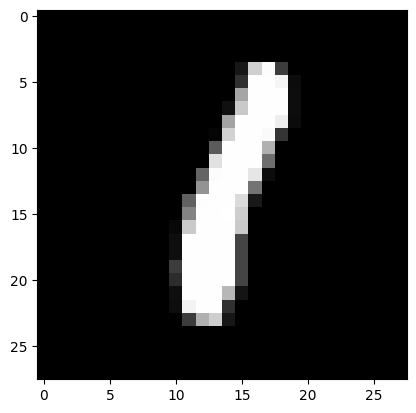

In [45]:
# проверим предсказание на случайном изображении из тестовой выборки
idx = np.random.randint(x_test.shape[0])
img = x_test[idx]

pred = model.predict(img.reshape(-1,784))
print('Prediction:', np.argmax(pred))

plt.imshow(img, cmap='gray')
plt.show()

In [46]:
# Сохраним модель
model.save('my_model.keras')

## Часть 6. Приложение

С помощью библиотеки gradio настроим приложение, позволяющее рисовать и подавать для предсказания пользователю цифру.

In [ ]:
# загружаем модель
model = load_model('my_model.keras')

In [49]:
def preprocess_image(image):
    """
    Предобработка изображения:

    """
    alpha_channel = image[:, :, 3]
    image = Image.fromarray(alpha_channel)
    image = image.resize((28, 28))
    image = np.array(image)
    image = image / 255.0
    image = image.reshape(1, 784)
    return image

In [50]:
def predict_number(image):
    """
    Функция для предсказания числа
    """
    try:
        image = image["composite"]
        preprocessed_image = preprocess_image(image)
        predictions = model.predict(preprocessed_image)
        predicted_class = np.argmax(predictions)
        probabilities = {str(i): round(float(predictions[0][i]) * 100, 2) for i in range(10)}
        probabilities_text = "\n".join([f"Класс {i}: {probabilities[str(i)]}%" for i in range(10)])
        return f"Предсказанное число: {predicted_class}\n\nВероятности:\n{probabilities_text}"

    except Exception as e:
        return f"Ошибка: {str(e)}"

In [51]:
interface = gr.Interface(
    fn=predict_number,
    inputs=gr.Sketchpad(label="Нарисуйте число", canvas_size=(400, 400)),
    outputs="text"
)

interface.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://c3c5d5d46d3800ee17.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c3c5d5d46d3800ee17.gradio.live
